# Task info
We have: Image of  traffic sign and label that identify.
Task is:


1.   model that achieves the best accuracy in recognition 
2.   and require the smallest amount of parameters
3.  to consider is inference time (how much time does it take to can prediction result for one image for trained model)




**Libraries**

In [0]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import (DataLoader, Dataset)
from collections import OrderedDict
import cv2
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [0]:
batch_size = 64
test_batch_size = 1
epochs = 10
learning_rate = 0.01
momentum = 0.5
random_seed = 42
logging_interval = 100
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()

# Layer details for the neural network
input_size = 32*32
hidden_sizes = [128, 64]
output_size = 43


torch.manual_seed(random_seed)
device = torch.device("cuda" if use_cuda else "cpu")

**Function for loading data:**

In [0]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features'].astype(np.float32)
        # 1D numpy.ndarray type, for train = (34799,)   
        target = d['labels'].astype(np.long)                       
        # 2D numpy.ndarray type, for train = (34799, 2) 
        sizes = d['sizes']                         
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']                        
       
    return input_data, target, sizes, coords

**Mounting drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


mean:  [0.29701364 0.26967433 0.27603114] 
std:  [0.2569489  0.24415684 0.25072676]
Train 
 features sizes:  (34799, 32, 32, 3) 
 target sizes:    (34799,)
Test 
 features sizes:  (4410, 32, 32, 3) 
 target sizes:    (4410,)

Classes:  43

Batch size:  64
Image size:  torch.Size([32, 32, 3])

Example of img: image num 900
label:  Go straight or right


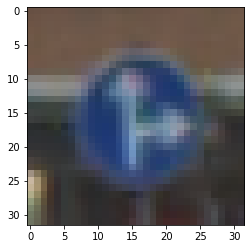

In [54]:
class LeDataSet(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        if self.transforms is not None:
            data = self.transforms(data)
        return (data.permute(1,2,0), label)

    def __len__(self):
        return len(self.X)

label_names = pd.read_csv("/content/drive/My Drive/label_names.csv")

X_train, y_train, train_sizes, train_coords = load_data("/content/drive/My Drive/train.pickle")
X_test, y_test, test_sizes, test_coords = load_data("/content/drive/My Drive/valid.pickle")

# mean and std for normalizing
mean = X_train.mean(axis=(0,1,2))/255
std = X_train.std(axis=(0,1,2))/255
print("mean: ", mean, "\nstd: ", std)

transform = transforms.Compose([transforms.ToTensor()])

trainset = LeDataSet(X_train, y_train, transforms=transform) 
testset = LeDataSet(X_test, y_test, transforms=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

n_classes = np.unique(y_train).shape[0]

print("Train \n features sizes: ", X_train.shape, "\n target sizes:   ", y_train.shape)
print("Test \n features sizes: ", X_test.shape, "\n target sizes:   ", y_test.shape)
print("\nClasses: ", n_classes)

dataiter = iter(train_loader)
images, labels = dataiter.next()

print("\nBatch size: ", images.shape[0])
print("Image size: ", images.shape[1:])

print("\nExample of img: image num 900")
plt.imshow(X_train[900].squeeze().astype('uint8'))
print("label: ", label_names.SignName[y_train[900]])

To check how unbalanced our dataset is:

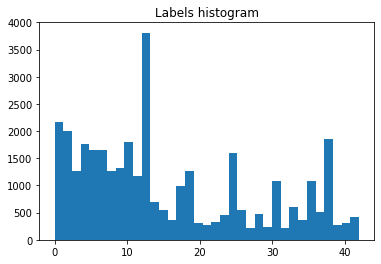

In [0]:
_ = plt.hist(y_train, bins='auto')
plt.title("Labels histogram")
plt.show()

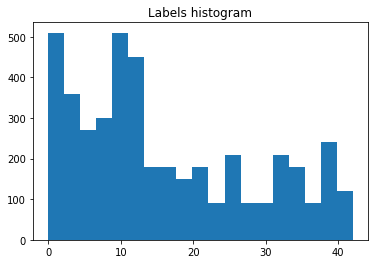

In [0]:
_ = plt.hist(y_test, bins='auto')
plt.title("Labels histogram")
plt.show()

And we can see that some labels have very small amount of images.

# Model:

In [0]:
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(3, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 43)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [0]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = data.to(device), target.to(device)
        data = data.permute(0,3,1,2)
        # data = data.view(data.shape[0], -1)
        optimizer.zero_grad()
        # try:
        output = model(data)
        # except:
        # print(data.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % logging_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [0]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            start = datetime.now()
            # data, target = data.to(device), target.to(device)
            # data = data.view(data.shape[0], -1)
            data = data.permute(0,3,1,2)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            end = datetime.now()

    print('Time to predict 1 test img : ', (end - start).total_seconds())  
    test_loss /= len(test_loader.dataset)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [0]:
def main():
    model = LeNet5()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
    

main()

Train Epoch: 1 [0/34799 (0%)]	Loss: 6.765800
Train Epoch: 1 [6400/34799 (18%)]	Loss: 3.276906
Train Epoch: 1 [12800/34799 (37%)]	Loss: 1.257428
Train Epoch: 1 [19200/34799 (55%)]	Loss: 0.649879
Train Epoch: 1 [25600/34799 (74%)]	Loss: 0.815097
Train Epoch: 1 [32000/34799 (92%)]	Loss: 0.883020
Time to predict 1 test img :  0.008273

Test set: Average loss: 0.8957, Accuracy: 3513/4410 (80%)

Train Epoch: 2 [0/34799 (0%)]	Loss: 0.571242
Train Epoch: 2 [6400/34799 (18%)]	Loss: 0.485440
Train Epoch: 2 [12800/34799 (37%)]	Loss: 0.347321
Train Epoch: 2 [19200/34799 (55%)]	Loss: 0.389859
Train Epoch: 2 [25600/34799 (74%)]	Loss: 0.198307
Train Epoch: 2 [32000/34799 (92%)]	Loss: 0.236597
Time to predict 1 test img :  0.007368

Test set: Average loss: 0.8402, Accuracy: 3664/4410 (83%)

Train Epoch: 3 [0/34799 (0%)]	Loss: 0.184947
Train Epoch: 3 [6400/34799 (18%)]	Loss: 0.320385
Train Epoch: 3 [12800/34799 (37%)]	Loss: 0.268013
Train Epoch: 3 [19200/34799 (55%)]	Loss: 0.189136
Train Epoch: 3 [2560

Trying to improve my model:

**Adding some img preprocessing from kaggle**

In [0]:
!pip install tqdm
import tensorflow as tf

In [0]:
from tqdm import tqdm

In [0]:
# Defining function for changing brightness
def brightness_changing(image):
    # Converting firstly image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Defining random value for changing brightness
    random_brightness = 0.25 + np.random.uniform()
    # Implementing changing of Value channel of HSV image
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * random_brightness
    # Converting HSV changed image to RGB
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    # Returning image with changed brightness
    return image_rgb
# Defining function for changing rotation of image
def rotation_changing(image):
    # Defining angle range
    angle_range = 25
    # Defining angle rotation
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    # Getting shape of image
    rows, columns, channels = image.shape
    # Implementing rotation
    # Calculating Affine Matrix
    affine_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    # Warping original image with Affine Matrix
    rotated_image = cv2.warpAffine(image, affine_matrix, (columns, rows))
    # Returning rotated image
    return rotated_image
# Defining function for transformation: brightness + rotation

def transformation_brightness_rotation(image):
    return brightness_changing(rotation_changing(image))


# Defining function for getting random image of one label
def random_image(x_train, y_train, y_number):
    # Getting indexes of needed 'y_number' from 'y_train'
    # Defining True - False array
    image_indexes = np.where(y_train == y_number)
    # Getting random index of needed label
    # 'np.bincount(y_train)' - array with number of examples for every label
    # 'np.bincount(y_train)[y_number] - 1' - number of examples for 'y_number' label
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    # Returning random image from 'x_train'
    # 'x_train[image_indexes]' - returns array with only 'y_number' label
    # 'x_train[image_indexes][random_index]' - random image of needed label
    return x_train[image_indexes][random_index]


# Defining function for equalization training dataset
def equalize_training_dataset(x_train, y_train):
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    # Showing progress ber with 'tqdm'
    for i in tqdm(number_of_labels):
        # Calculating how many examples is needed to add for current label
        # 'np.mean(number_of_examples_for_every_label)' - average number over examples for every label
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        # Defining temporary arrays for collecting new images
        x_temp = []
        y_temp = []

        # Getting random image from current label
        # Transforming it and adding to the temporary arrays
      
        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(transformation_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train

In [0]:
x_train_eq, y_train_eq = equalize_training_dataset(X_train, y_train)

100%|██████████| 43/43 [01:26<00:00,  1.90s/it]


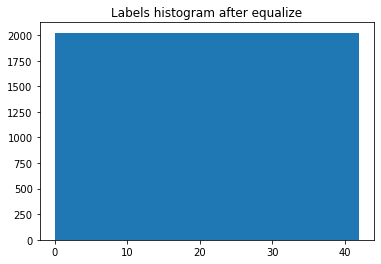

In [0]:
_ = plt.hist(y_train_eq, bins='auto')
plt.title("Labels histogram after equalize")
plt.show()

In [0]:
trainset = LeDataSet(x_train_eq, y_train_eq, transforms=transform) 
testset = LeDataSet(X_test, y_test, transforms=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
def main2():
    model = LeNet5()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)

main2()

Train Epoch: 1 [0/86989 (0%)]	Loss: 4.187910
Train Epoch: 1 [6400/86989 (7%)]	Loss: 3.168797
Train Epoch: 1 [12800/86989 (15%)]	Loss: 2.033044
Train Epoch: 1 [19200/86989 (22%)]	Loss: 1.295110
Train Epoch: 1 [25600/86989 (29%)]	Loss: 0.809029
Train Epoch: 1 [32000/86989 (37%)]	Loss: 0.756384
Train Epoch: 1 [38400/86989 (44%)]	Loss: 0.396256
Train Epoch: 1 [44800/86989 (51%)]	Loss: 0.589873
Train Epoch: 1 [51200/86989 (59%)]	Loss: 0.693508
Train Epoch: 1 [57600/86989 (66%)]	Loss: 0.441648
Train Epoch: 1 [64000/86989 (74%)]	Loss: 0.610893
Train Epoch: 1 [70400/86989 (81%)]	Loss: 0.248779
Train Epoch: 1 [76800/86989 (88%)]	Loss: 0.485170
Train Epoch: 1 [83200/86989 (96%)]	Loss: 0.327564
Time to predict 1 test img :  0.007791

Test set: Average loss: 1.3876, Accuracy: 3508/4410 (80%)

Train Epoch: 2 [0/86989 (0%)]	Loss: 0.536606
Train Epoch: 2 [6400/86989 (7%)]	Loss: 0.453863
Train Epoch: 2 [12800/86989 (15%)]	Loss: 0.376939
Train Epoch: 2 [19200/86989 (22%)]	Loss: 0.259843
Train Epoch: 2 

We can see that accuracy becomes better, but just for a little: 1-2 %

**To sum up**, adding more data with kaggle functions gave us better accuracy, but with grayscale imgs and rotate it could become much more better.